In [1]:
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from bs4 import BeautifulSoup
from bs4.element import Comment
import re
from langdetect import detect_langs

from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

In [89]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
df = pd.read_csv(os.path.join('..', '..', 'data', 'yelp_data', 'updated', 'business.csv'))
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,url,webpage_text
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'...",http://www.therangeatlakenorman.com/,"b'<!DOCTYPE html>\n<html lang=""en-US"">\n<head>..."
1,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,NaN,"Pets, Pet Services, Pet Groomers",NaN,http://www.felinus.ca,"b'<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0..."
2,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726649,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...",https://www.usemyguyservices.com,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""..."
3,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Oil Change Stations, ...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",http://oasisautocenter.net,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""..."
4,ScYkbYNkDgCneBrD9vqhCQ,Junction Tire & Auto Service,6910 E Southern Ave,Mesa,AZ,85209,33.393885,-111.682226,5.0,18,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Auto Repair, Oil Change Stations, Automotive, ...","{'Monday': '7:30-17:0', 'Tuesday': '7:30-17:0'...",http://junctiontire.net/tires-auto-repair-mesa-az,"b'<!DOCTYPE html>\r\n<html lang=""en"">\r\n<head..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56065 entries, 0 to 56064
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   56065 non-null  object 
 1   name          56065 non-null  object 
 2   address       53689 non-null  object 
 3   city          56065 non-null  object 
 4   state         56065 non-null  object 
 5   postal_code   55956 non-null  object 
 6   latitude      56065 non-null  float64
 7   longitude     56065 non-null  float64
 8   stars         56065 non-null  float64
 9   review_count  56065 non-null  int64  
 10  is_open       56065 non-null  int64  
 11  attributes    48188 non-null  object 
 12  categories    55963 non-null  object 
 13  hours         45045 non-null  object 
 14  url           56065 non-null  object 
 15  webpage_text  50471 non-null  object 
dtypes: float64(3), int64(2), object(11)
memory usage: 6.8+ MB


In [5]:
classes = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

#convert column stars to one hot encoding
df['stars'] = pd.Categorical(df['stars'], categories=classes)
dummies = pd.get_dummies(df['stars'])
df = pd.concat([df, dummies], axis=1)

In [6]:
df[classes].head()

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1


In [7]:
train_sz = int(len(df) * 0.8)
train = df[:train_sz]
test = df[train_sz:]

In [8]:
def visible_tags(item):
    return not item.parent.name in {'meta', 'head', 'script', 'style', '[document]'} and not isinstance(item, Comment)

def get_corpus(df, output_path=None, df_address_with_corpus=None):
        
    if not df_address_with_corpus is None:
        df = pd.read_csv(df_address_with_corpus)
    else:
        if os.path.isdir(output_path) is False:
            print('Error: the output path does not exists!')
            return
        is_eng = []
        webpage_corpus = []
        max_text_size = 20 # maximum size for language detection

        for page_content in tqdm(df['webpage_text']):
            is_eng.append(False)
            webpage_corpus.append(None)
            if page_content is np.nan: continue
            try:
                soup = BeautifulSoup(page_content, 'html.parser')
            except:
                continue
            texts = soup.findAll(text=True)
            visible_texts = filter(visible_tags, texts)
            visible_texts = u' '.join(s.strip() for s in visible_texts)
            if visible_texts is None: continue
            visible_texts = visible_texts.replace('`', '')
            #print(visible_texts[:100])
            visible_texts = visible_texts.replace('\\n', ' ').replace('\\r', '').replace('\\t', '')
            #visible_texts = re.sub('\\?', '', visible_texts)
            visible_texts = re.sub('[^a-zA-Z0-9\s]', '', visible_texts)
            visible_texts = visible_texts.split()
            visible_texts = ' '.join(visible_texts)
            try:
                langs = detect_langs(visible_texts[:max_text_size])
                for i in range(min(2, len(langs))):
                    if langs[i].lang == 'en':
                        is_eng[-1] = True
                        webpage_corpus[-1] = visible_texts
            except Exception as e:
                #print(e)
                pass

        df['is_eng'] = is_eng
        df['webpage_corpus'] = webpage_corpus
        try:
            output_path = '' if output_path is None else output_path
            df.to_csv(os.path.join(output_path, 'bussiness_with_corpus.csv'))
        except Exception as e:
            print(e)
    return df

In [9]:
df = get_corpus(df, output_path=None, df_address_with_corpus=os.path.join('..', '..', 'data', 'yelp_data', 'updated', 'bussiness_with_corpus.csv'))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56065 entries, 0 to 56064
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      56065 non-null  int64  
 1   business_id     56065 non-null  object 
 2   name            56065 non-null  object 
 3   address         53689 non-null  object 
 4   city            56065 non-null  object 
 5   state           56065 non-null  object 
 6   postal_code     55956 non-null  object 
 7   latitude        56065 non-null  float64
 8   longitude       56065 non-null  float64
 9   stars           56065 non-null  float64
 10  review_count    56065 non-null  int64  
 11  is_open         56065 non-null  int64  
 12  attributes      48188 non-null  object 
 13  categories      55963 non-null  object 
 14  hours           45045 non-null  object 
 15  url             56065 non-null  object 
 16  webpage_text    50471 non-null  object 
 17  1.0             56065 non-null 

In [123]:
for i in range(3):
    print(i, df['webpage_corpus'][i])
    print('*' * 100)

0 Shooting Ranges Gun Rental Charlotte NC The Range at Lake Norman Skip to content Menu Home Contact Hours FaceBook FAQ Calendar Shoot with us Lane reservations Personal instruction Memberships Membership Levels Range Rules Ammo policy Daily Rates Rental firearms The Simulator Parties Events Ladies night Try a Firearm Competitive Shooting Firearm Sales and Transfers Purchase a firearm Firearms Consultation Transfers NFA Devices Exchange Program Safes About Gunsmithing and Restoration Gun Services What People are Saying Helpful Links Cart State of the Art Indoor Shooting Range The Range at Lake Norman the Charlotte areas Premier NSSF Five Star Shooting range is a state of the art indoor firearms shooting range and training center located in Cornelius NCxc2xa0 We offer indoor shooting ranges for rifles pistols and shotgunsxc2xa0 Our lanes are all video monitored and climate controlled offering a comfortable shooting environmentxc2xa0 We offer the most technologically advanced and cleanes

In [11]:
train_sz = int(len(df) * 0.8)
train = df[:train_sz]
test = df[train_sz:]

In [47]:
set(df['stars'])

{1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}

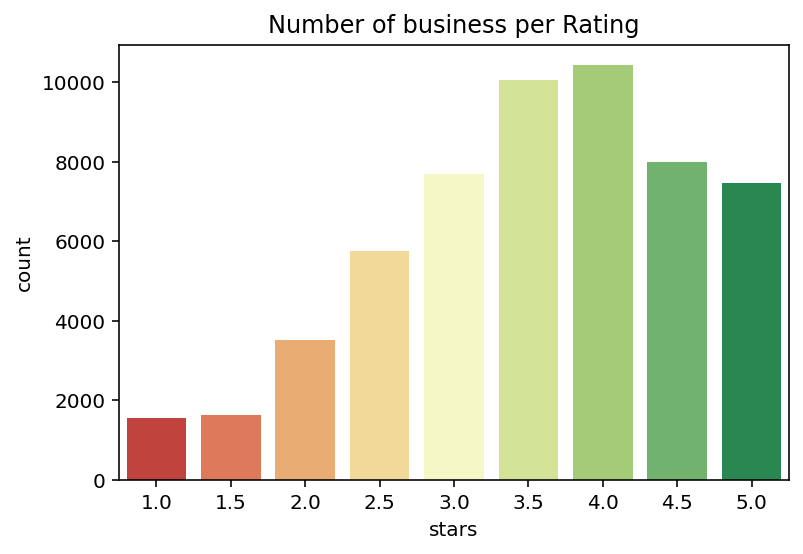

In [46]:
chart = sns.countplot(df['stars'], palette='RdYlGn')
plt.title('Number of business per Rating')
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='center');

In [124]:
class RateWebsites:    
    def __init__(self, train, test, tokenizer: FullTokenizer, text_colname=None, label_colname=None, max_seq_len=128):
        """  
        """
        self.text_colname = 'webpage_corpus' if text_colname is None else text_colname
        if not self.text_colname in train.columns or not self.text_colname in test.columns:
            print('Error: Please specify a proper column name in the input dataframe as the corpus.')
            return
        
        self.label_colname = 'stars' if label_colname is None else label_colname
        if not self.label_colname in train.columns or not self.label_colname in test.columns:
            print('Error: Please specify a proper column name in the input dataframe as the labels.')
            return
        
        self.classes = train[self.label_colname].unique().astype('float32').tolist()
        self.classes.sort()
        
        train = train.dropna(subset=[self.text_colname])
        test = test.dropna(subset=[self.text_colname])
        
        self.max_seq_len = 0
        self.tokenizer = tokenizer
        (self.train_x, self.train_y), (self.test_x, self.test_y) = map(self._tokanize, [train, test])
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._cut_with_padding, [self.train_x, self.test_x])
    
    def build_model(self, bert_config_file, bert_ckpt_file, dropout=0.6):
        """
        """
        bert = self._load_bert(bert_config_file, bert_ckpt_file)
        input_ = keras.layers.Input(shape=(self.max_seq_len, ), dtype='int64')
        x = bert(input_)
        #get the first embedding from the output of BERT
        x = keras.layers.Lambda(lambda seq: seq[:,0,:])(x)
        
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(300, activation='relu')(x)
        x = keras.layers.Dense(300, activation='relu')(x)
        output_ = keras.layers.Dense(units=len(self.classes), activation='softmax')(x)
        
        model = keras.Model(inputs=input_, outputs=output_)
        model.build(input_shape=(None, self.max_seq_len))
        
        load_stock_weights(bert, bert_ckpt_file)
        
        return model
    
    def _load_bert(self, bert_config_file, bert_ckpt_file):
        try:
            with tf.io.gfile.GFile(bert_config_file, 'r') as gf:
                bert_config = StockBertConfig.from_json_string(gf.read())
                bert_params = map_stock_config_to_params(bert_config)
                bert_params.adapter_size = None
                bert = BertModelLayer.from_params(bert_params, name='bert')
                return bert
        except Exception as e:
            print(e)
    
    def _tokanize(self, df):
        """
        """
        X, y = [], []
        for _, entry in tqdm(df.iterrows()):
            corpus, label = entry[self.text_colname], entry[self.label_colname]
            tokens = self.tokenizer.tokenize(corpus)
            tokens = ['[CLS]'] + tokens + ['[SEP]']
            ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(ids))
            X.append(ids)
            y.append(self.classes.index(label))
        return np.asarray(X), np.asarray(y)
    
    def _cut_with_padding(self, ids):
        """
        """
        X = []
        CLS_id = self.tokenizer.convert_tokens_to_ids(['[CLS]'])
        SEP_id = self.tokenizer.convert_tokens_to_ids(['[SEP]'])
        for token_id in ids:
            # ignore tokens '[CLS]' and '[SEP]' for now
            arr = token_id[1:-1]
            sz = min(len(arr), self.max_seq_len - 2)
            arr = CLS_id + arr[:sz] + SEP_id
            # pad the remaining cells with zero
            arr = arr + [0] * (self.max_seq_len - len(arr))
            X.append(np.asarray(arr))
        return np.asarray(X)

In [125]:
folder_path = os.path.join('..', '..', 'data','uncased_L-12_H-768_A-12')
tokenizer = FullTokenizer(vocab_file=os.path.join(folder_path, 'vocab.txt'))

bert_ckpt_file = os.path.join(folder_path, 'bert_model.ckpt')
bert_config_file = os.path.join(folder_path, 'bert_config.json')

tokens_test = tokenizer.tokenize('This is an open-source project for rating businesses based on their website quality!')
print(tokens_test)
print(tokenizer.convert_tokens_to_ids(tokens_test))

['this', 'is', 'an', 'open', '-', 'source', 'project', 'for', 'rating', 'businesses', 'based', 'on', 'their', 'website', 'quality', '!']
[2023, 2003, 2019, 2330, 1011, 3120, 2622, 2005, 5790, 5661, 2241, 2006, 2037, 4037, 3737, 999]


In [126]:
def compile_model(rater:RateWebsites, model):
    model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])
    print(model.summary())
    history = model.fit(
        x=rater.train_x,
        y=rater.train_y,
        validation_split=0.05,
        batch_size=64,
        shuffle=True,
        epochs=10
    )

In [127]:
rater = RateWebsites(train, test, tokenizer, max_seq_len=100)
model = rater.build_model(bert_config_file, bert_ckpt_file)

26096it [05:01, 86.47it/s] 
6499it [01:12, 89.50it/s] 


<class 'bert.model.BertModelLayer'>
Done loading 196 BERT weights from: ../../data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f942c1b9750> (prefix:bert_6). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [129]:
compile_model(rater, model)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 100, 768)          108890112 
_________________________________________________________________
lambda_6 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 300)               230700    
_________________________________________________________________
dense_16 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 2709

In [130]:
loss, acc = model.evaluate(rater.test_x, rater.test_y)

204/204 [==============================] - 18s 86ms/step - loss: 2.1883 - acc: 0.1689


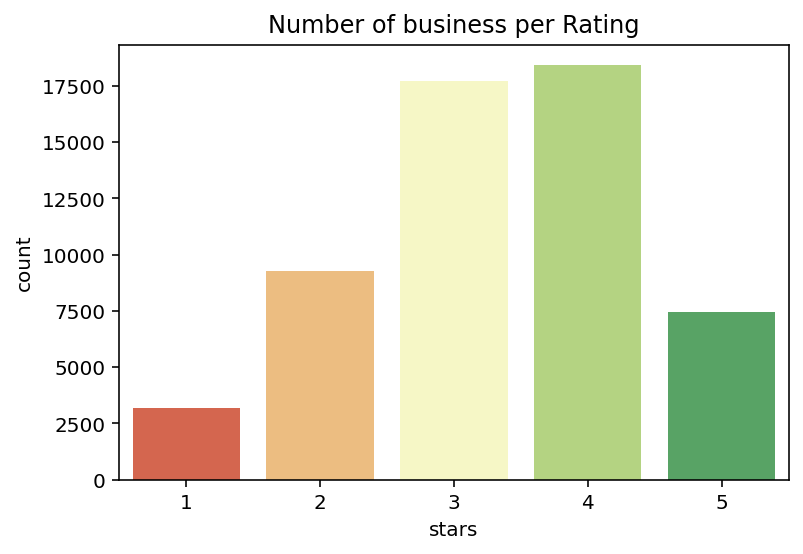

In [131]:
df2 = df.copy(deep=True)
df2['stars'] = df2['stars'].apply(lambda x: int(x))
train_sz = int(len(df) * 0.8)
train2 = df2[:train_sz]
test2 = df2[train_sz:]
chart = sns.countplot(df2['stars'], palette='RdYlGn')
plt.title('Number of business per Rating')
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='center');

In [132]:
rater2 = RateWebsites(train2, test2, tokenizer, max_seq_len=100)

26096it [04:44, 91.65it/s] 
6499it [01:09, 92.91it/s] 


<class 'bert.model.BertModelLayer'>
Done loading 196 BERT weights from: ../../data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f9030ea3450> (prefix:bert_7). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [135]:
model2 = rater2.build_model(bert_config_file, bert_ckpt_file)

<class 'bert.model.BertModelLayer'>
Done loading 196 BERT weights from: ../../data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f9027cf2b90> (prefix:bert_8). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [136]:
compile_model(rater2, model2)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 100, 768)          108890112 
_________________________________________________________________
lambda_8 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 300)               230700    
_________________________________________________________________
dense_22 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 1505

In [137]:
model2.evaluate(rater2.test_x, rater2.test_y)

204/204 [==============================] - 18s 86ms/step - loss: 1.5612 - acc: 0.3301


[1.5611721277236938, 0.3300507664680481]

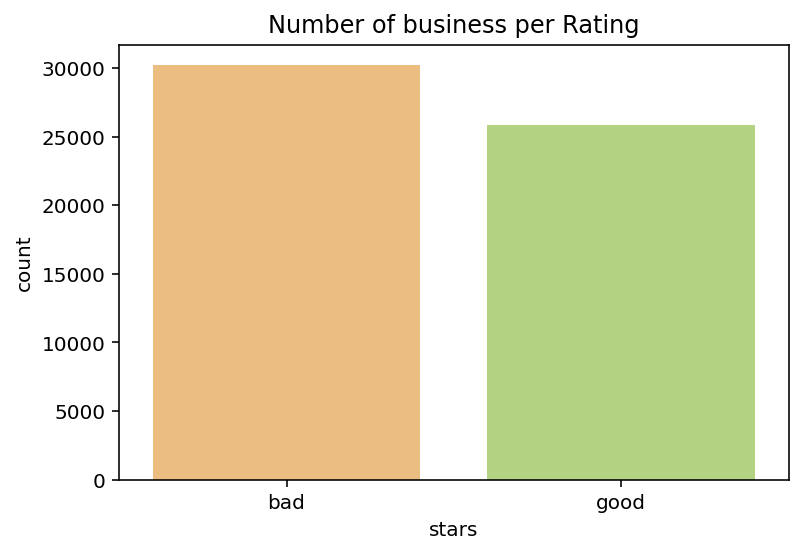

In [142]:
df3 = df.copy(deep=True)
df3['stars'] = df3['stars'].apply(lambda x: 0 if int(x) <= 3 else 1)
train_sz = int(len(df3) * 0.8)
train3 = df3[:train_sz]
test3 = df3[train_sz:]
chart = sns.countplot(df3['stars'], palette='RdYlGn')
plt.title('Number of business per Rating')
chart.set_xticklabels(['bad', 'good'], horizontalalignment='center');

In [143]:
rater3 = RateWebsites(train3, test3, tokenizer, max_seq_len=100)

26096it [04:46, 90.93it/s] 
6499it [01:10, 91.69it/s] 


<class 'bert.model.BertModelLayer'>
Done loading 196 BERT weights from: ../../data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f902cd16bd0> (prefix:bert_10). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [146]:
model3 = rater3.build_model(bert_config_file, bert_ckpt_file)

<class 'bert.model.BertModelLayer'>
Done loading 196 BERT weights from: ../../data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f902cf7ecd0> (prefix:bert_11). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [147]:
compile_model(rater3, model3)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 100, 768)          108890112 
_________________________________________________________________
lambda_11 (Lambda)           (None, 768)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 300)               230700    
_________________________________________________________________
dense_31 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 602

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[64,100,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_11/bert/encoder/layer_10/intermediate/mul_3/Mul_1 (defined at <ipython-input-126-948f7d0cc2e6>:12) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[gradient_tape/model_11/bert/embeddings/word_embeddings/embedding_lookup/Reshape/_550]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[64,100,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_11/bert/encoder/layer_10/intermediate/mul_3/Mul_1 (defined at <ipython-input-126-948f7d0cc2e6>:12) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_503620]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/model_11/bert/encoder/layer_10/intermediate/mul_3/Mul_1:
 model_11/bert/encoder/layer_10/intermediate/BiasAdd (defined at /opt/conda/lib/python3.7/site-packages/bert/transformer.py:179)

Input Source operations connected to node gradient_tape/model_11/bert/encoder/layer_10/intermediate/mul_3/Mul_1:
 model_11/bert/encoder/layer_10/intermediate/BiasAdd (defined at /opt/conda/lib/python3.7/site-packages/bert/transformer.py:179)

Function call stack:
train_function -> train_function
